(6000, 7)
Training Features Shape: (900, 3)
Training Labels Shape: (900, 4)
Testing Features Shape: (900, 3)
Testing Labels Shape: (900, 4)
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.1s finished


Complexity and bandwidth selected and model fitted in 9.635743 s

The model performance for training set
--------------------------------------
MAE is 8.678154732522467e-31
MSE is 2.7607626364739543e-60
EVS is 1.0
R2 score is 1.0

The model performance for testing set
--------------------------------------
MAE is 3.3549349082222325e-18
MSE is 5.9876288390657e-35
EVS is 0.9988861360314663
R2 score is 0.9988793026516432

Best parameters set found on development set:
{'criterion': 'mse', 'n_estimators': 500}

Complexity and bandwidth selected and model fitted in 1.400981 s
Feature: 0, Score: 0.05884
Feature: 1, Score: 0.18806
Feature: 2, Score: 0.75310


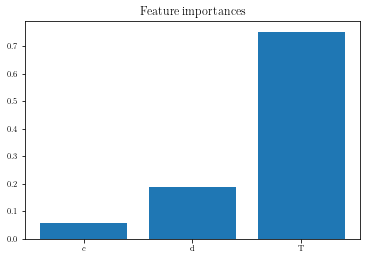

Prediction for 900 inputs in 0.164402 s
Mean Absolute Error (MAE): 0.019048644644709935
Mean Squared Error (MSE): 0.0011000817171186509
Root Mean Squared Error (RMSE): 0.03316747981259129


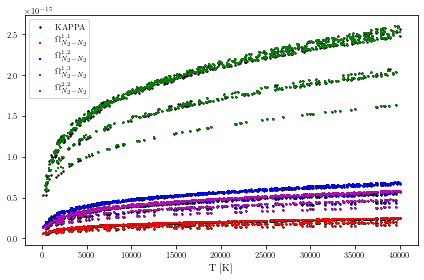

In [7]:
#!/usr/bin/env python

import time
import sys
sys.path.insert(0, '../../Utilities/')

from plotting import newfig, savefig
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import pandas as pd
import seaborn as sns

import operator
import itertools

from sklearn import metrics
from sklearn.metrics import *

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score

from sklearn.inspection import permutation_importance

from sklearn import ensemble
from sklearn.ensemble import ExtraTreesRegressor

from joblib import dump, load
import pickle

n_jobs = -1
trial  = 1

dataset=np.loadtxt("data/omega_integrals_encoded.txt")
print(dataset.shape) # 6000 x 7

x = dataset[:,0:3] # c, d, T
y = dataset[:,3:] # Ω(1,1), Ω(1,2), Ω(1,3), Ω(2,2)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.15, test_size=0.15, random_state=69)

sc_x = StandardScaler()
sc_y = StandardScaler()

# fit scaler
sc_x.fit(x_train)

# transform training dataset
x_train = sc_x.transform(x_train)

# transform test dataset
x_test = sc_x.transform(x_test)

# fit scaler on training dataset
sc_y.fit(y_train)

# transform training dataset
y_train = sc_y.transform(y_train)

# transform test dataset
y_test = sc_y.transform(y_test)

dump(sc_x, open('scaler_x.pkl', 'wb'))
dump(sc_y, open('scaler_y.pkl', 'wb'))

print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:',   y_train.shape)
print('Testing Features Shape:',  x_test.shape)
print('Testing Labels Shape:',    y_test.shape)

# Extra Trees
hyper_params = [{'n_estimators': (1, 100, 500,),
                 #'min_weight_fraction_leaf': (0.0,),
                 #'max_features': ('sqrt','log2',),
                 #'max_samples': (1, 10, 100, 200, 300, 500),
                 'criterion': ('mse',),
                 #'bootstrap': (True, False,),
                 #'oob_score': (True, False,),
                 #'warm_start': (True, False,),
                 #'criterion': ('mse', 'mae',),
                 #'max_depth': (1, 10, 100, None,),
                 #'max_leaf_nodes': (2, 100, 200, 500),
                 #'min_samples_split': (10,),
                 #'min_samples_leaf': (1, 10, 100,),
}]

est=ensemble.ExtraTreesRegressor(random_state=69)
gs = GridSearchCV(est, cv=10, param_grid=hyper_params, verbose=2, n_jobs=n_jobs, scoring='r2')

t0 = time.time()
gs.fit(x_train, y_train)
runtime = time.time() - t0
print("Complexity and bandwidth selected and model fitted in %.6f s" % runtime)

train_score_mse = mean_squared_error(      sc_y.inverse_transform(y_train), sc_y.inverse_transform(gs.predict(x_train)))
train_score_mae = mean_absolute_error(     sc_y.inverse_transform(y_train), sc_y.inverse_transform(gs.predict(x_train)))
train_score_evs = explained_variance_score(sc_y.inverse_transform(y_train), sc_y.inverse_transform(gs.predict(x_train)))
#train_score_me  = max_error(               sc_y.inverse_transform(y_train), sc_y.inverse_transform(gs.predict(x_train)))
train_score_r2  = r2_score(                sc_y.inverse_transform(y_train), sc_y.inverse_transform(gs.predict(x_train)))

test_score_mse  = mean_squared_error(      sc_y.inverse_transform(y_test),  sc_y.inverse_transform(gs.predict(x_test)))
test_score_mae  = mean_absolute_error(     sc_y.inverse_transform(y_test),  sc_y.inverse_transform(gs.predict(x_test)))
test_score_evs  = explained_variance_score(sc_y.inverse_transform(y_test),  sc_y.inverse_transform(gs.predict(x_test)))
#test_score_me   = max_error(               sc_y.inverse_transform(y_test),  sc_y.inverse_transform(gs.predict(x_test)))
test_score_r2   = r2_score(                sc_y.inverse_transform(y_test),  sc_y.inverse_transform(gs.predict(x_test)))

print()
print("The model performance for training set")
print("--------------------------------------")
print('MAE is {}'.format(train_score_mae))
print('MSE is {}'.format(train_score_mse))
print('EVS is {}'.format(train_score_evs))
#print('ME is {}'.format(train_score_me))
print('R2 score is {}'.format(train_score_r2))
print()
print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(test_score_mae))
print('MSE is {}'.format(test_score_mse))
print('EVS is {}'.format(test_score_evs))
#print('ME is {}'.format(test_score_me))
print('R2 score is {}'.format(test_score_r2))
print()
print("Best parameters set found on development set:")
print(gs.best_params_)
print()

# Re-train with best parameters
regr = ExtraTreesRegressor(**gs.best_params_, random_state=69)

t0 = time.time()
regr.fit(x_train, y_train)
regr_fit = time.time() - t0
print("Complexity and bandwidth selected and model fitted in %.6f s" % regr_fit)

importance = regr.feature_importances_                                                                                              
                                                                                                                                     
# summarize feature importance                                                                                                      
for i,v in enumerate(importance):                                                                                                   
    print('Feature: %0d, Score: %.5f' % (i,v))                                                                                  
                                                                                                                                     
# plot feature importance                                                                                                           
plt.title("Feature importances")                                                                                                    
features = np.array(['c', 'd', 'T'])                                              
plt.bar(features, importance)                                                                                                      
#plt.bar([x for x in range(len(importance))], importance)                                                                            
plt.savefig("importance.pdf", dpi=150, crop='false')                                                                                
plt.show()                                                                                                                          
plt.close() 
    
t0 = time.time()
y_regr = regr.predict(x_test)
regr_predict = time.time() - t0
print("Prediction for %d inputs in %.6f s" % (x_test.shape[0], regr_predict))

with open('output.log', 'w') as f:
    print("Training time: %.6f s" % regr_fit, file=f)
    print("Prediction time: %.6f s" % regr_predict, file=f)
    print(" ", file=f)
    print("The model performance for training set", file=f)
    print("--------------------------------------", file=f)
    print('MAE is {}'.format(train_score_mae), file=f)
    print('MSE is {}'.format(train_score_mse), file=f)
    print('EVS is {}'.format(train_score_evs), file=f)
   # print('ME is {}'.format(train_score_me), file=f)
    print('R2 score is {}'.format(train_score_r2), file=f)
    print(" ", file=f)
    print("The model performance for testing set", file=f)
    print("--------------------------------------", file=f)
    print('MAE is {}'.format(test_score_mae), file=f)
    print('MSE is {}'.format(test_score_mse), file=f)
    print('EVS is {}'.format(test_score_evs), file=f)
    #print('ME is {}'.format(test_score_me), file=f)
    print('R2 score is {}'.format(test_score_r2), file=f)
    print(" ", file=f)
    print("Adimensional test metrics", file=f)
    print("--------------------------------------", file=f)
    print('Mean Absolute Error (MAE):',              mean_absolute_error(y_test, y_regr), file=f)
    print('Mean Squared Error (MSE):',               mean_squared_error(y_test, y_regr), file=f)
    print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, y_regr)), file=f)
    print(" ", file=f)
    print("Best parameters set found on development set:", file=f)
    print(gs.best_params_, file=f)

print('Mean Absolute Error (MAE):',              mean_absolute_error(y_test, y_regr))
print('Mean Squared Error (MSE):',               mean_squared_error(y_test, y_regr))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, y_regr)))

x_test_dim = sc_x.inverse_transform(x_test)
y_test_dim = sc_y.inverse_transform(y_test)
y_regr_dim = sc_y.inverse_transform(y_regr)

plt.scatter(x_test_dim[:,2], y_test_dim[:,0], s=2, c='k', marker='o', label='KAPPA')
plt.scatter(x_test_dim[:,2], y_regr_dim[:,0], s=2, c='r', marker='+', label=r'$\Omega_{N_{2}-N_{2}}^{1,1}$')
#
plt.scatter(x_test_dim[:,2], y_test_dim[:,1], s=2, c='k', marker='o')
plt.scatter(x_test_dim[:,2], y_regr_dim[:,1], s=2, c='b', marker='+', label=r'$\Omega_{N_{2}-N_{2}}^{1,2}$')
#
plt.scatter(x_test_dim[:,2], y_test_dim[:,2], s=2, c='k', marker='o')
plt.scatter(x_test_dim[:,2], y_regr_dim[:,2], s=2, c='g', marker='+', label=r'$\Omega_{N_{2}-N_{2}}^{1,3}$')
#
plt.scatter(x_test_dim[:,2], y_test_dim[:,3], s=2, c='k', marker='o')
plt.scatter(x_test_dim[:,2], y_regr_dim[:,3], s=2, c='m', marker='+', label=r'$\Omega_{N_{2}-N_{2}}^{2,2}$')
#
plt.xlabel('T [K] ')
plt.legend()
plt.tight_layout()
plt.savefig("regression.pdf", dpi=150, crop='false')
plt.show()
plt.close()

# save the model to disk
#dump(gs, 'model.sav')